In [1]:
import time
import os
import sys
import copy
import pickle
import networkx as nx
import pandas as pd
import numpy as np

import itertools
import sklearn
import torch
import datetime
import matplotlib, matplotlib.pyplot as plt
from collections import defaultdict
from scipy import sparse

from torch.autograd import Variable
from models.models import MLP
from data import datasets
from data.gene_graphs import GeneManiaGraph, RegNetGraph
from data.utils import record_result
from data.clinical.datasets import TCGADataset, Task
from data.clinical import taskloader
from data.clinical import split_dataset

from models.models import MLP, GCN, SLR

%load_ext autoreload
%autoreload 2

In [2]:
# Load the gene expression dataset
tcga = TCGADataset()

# Cut it into clinical tasks
task_ids = taskloader.get_all_tasks(tcga)
tasks = [Task(tcga, task_id, limit=1000) for task_id in task_ids]

# load the gene-gene interaction graph
graphs = {"genemania": GeneManiaGraph()}

Torrent name: TCGA_tissue_ppi.hdf5, Size: 1748.32MB
Torrent name: genemania.pkl, Size: 9.61MB


In [10]:
# We store our results for this experiment in this file, it is tracked in git and contains a pickled pandas DataFrame 
filename = "experiments/results/clinical-tasks.pkl"
try:
    # try to load the results file
    results = pickle.load(open(filename, "rb"), encoding='latin1')
    print("Loaded Checkpointed Results")
except Exception as e:
    print(e)
    # If we can't find the results file, instantiate a new dataframe
    results = pd.DataFrame(columns=['task', 'auc', 'model', 'graph', 'seed', 'train_size', 'time_elapsed'])
    print("Created a New Results Dictionary")


Loaded Checkpointed Results


In [11]:
# Define the experimental conditions to evaluate
trials = 3
train_size = 50
test_size = 200
cuda = False
models = [
              #GCN(name="GCN_lay20_chan32_emb32_dropout_pool_kmeans", cuda=cuda, dropout=True, num_layer=4, channels=32, embedding=32, prepool_extralayers=5, pooling="kmeans"),
              # GCN(name="GCN_lay20_chan32_emb32_dropout_pool_hierarchy", cuda=cuda, dropout=True, num_layer=4, channels=32, embedding=32, prepool_extralayers=5, pooling="hierarchy"),
              #GCN(name="GCN_lay20_chan32_emb32_dropout_pool_random", cuda=cuda, dropout=True,num_layer=4, channels=32, embedding=32, prepool_extralayers=5, pooling="random"),
              GCN(name="GCN_lay3_chan64_emb32_dropout_pool_hierarchy", cuda=cuda, dropout=True, num_layer=3, channels=64, embedding=32, pooling="hierarchy"),
              GCN(name="GCN_lay3_chan64_emb32_dropout", cuda=cuda, dropout=True, num_layer=3, channels=64, embedding=32),
              MLP(name="MLP_lay2_chan512_dropout", cuda=cuda, dropout=True, num_layer=2, channels=512),
              MLP(name="MLP_lay2_chan512", cuda=cuda, dropout=False, num_layer=2, channels=512),
              #SLR(name="SLR_lambda1_l11", cuda=cuda)
             ]

In [12]:
# We create a unique identifier for each experiment, and find the experiments which we still have to do (i.e. not in results file)

columns = ["task", "graph", "model", "seed", "train_size"]
all_exp_ids = [x for x in itertools.product([task.id for task in tasks], graphs.keys(), [model.name for model in models], range(trials), [train_size])]
all_exp_ids = pd.DataFrame(all_exp_ids, columns=columns)
all_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in all_exp_ids.itertuples(name=None)]
results_exp_ids = results[columns].copy()
results_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in results_exp_ids.itertuples(name=None)]
intersection_ids = all_exp_ids.index.intersection(results_exp_ids.index)
todo = all_exp_ids.drop(intersection_ids).to_dict(orient="records")

print("todo: " + str(len(todo)))
print("done: " + str(len(results)))

todo: 3492
done: 1


In [13]:
for row in todo:

    start_time = time.time()
        
    # Get the experimental conditions
    graph_name = row["graph"]
    gene_graph = graphs[graph_name]
    seed = row["seed"]
    model = [model for model in models if model.name == row["model"]][0]
    task = [task for task in tasks if task.id == row["task"]][0]
    test_size = min(test_size, len(task.labels - train_size))
    experiment = {
        "task": task.id,
        "model": model.name,
        "graph": graph_name,
        "seed": seed,
        "train_size": train_size,
    }

    print(experiment)
    if len(results) % 10 == 0: print(len(results))

    try:
        # Split the dataset into train and test sets
        X_train, X_test, y_train, y_test = sklearn.model_selection.\
            train_test_split(task.get_data(), task.labels, stratify=task.labels, 
                             train_size=train_size, test_size=test_size)
    except ValueError as e:
        # If the task is too unbalanced, we don't run the experiment and record a result
        print(e)
        results = record_result(results, experiment, filename)
        continue
#     def get_every_n(a, n=2):
#     for i in range(a.shape[0] // 2):
#         yield a[2*i:2*(i+1)]        

    # Copy the data out of the task
    X_train = X_train.copy()
    X_test = X_test.copy()
    y_train = y_train.astype("uint8")

    # Try to fit the model
    try:
        model.fit(X_train, y_train, adj=np.asarray(nx.to_numpy_matrix(gene_graph.nx_graph)))
        x_test = Variable(torch.FloatTensor(np.expand_dims(X_test.values, axis=2)), requires_grad=False).float()
        if cuda: 
            x_test = x_test.cuda()

        y_hat = []
        for i in range(x_test.shape[0] // 10):
            batch = x_test[2*i:2*(i+1)]
            y_hat.extend(model.predict(batch)[:,1].data.cpu().numpy().tolist())
#         for chunk in get_every_n(x_test, 10):
#             y_hat.extend(model.predict(chunk)[:,1].data.cpu().numpy().tolist())
        auc = sklearn.metrics.roc_auc_score(y_test, np.asarray(y_hat).flatten())
        experiment["auc"] = auc
        experiment["time_elapsed"] = str(time.time() - start_time)
        experiment["cuda"] = cuda
        print(experiment)
        results = record_result(results, experiment, filename)
    except Exception as e:
        print(e)
    

{'task': 'gender-GBMLGG', 'model': 'GCN_lay3_chan64_emb32_dropout_pool_hierarchy', 'graph': 'genemania', 'seed': 0, 'train_size': 50}
> /Users/martinweiss/code/academic/gene-graph-conv/models/utils.py(140)setup_aggregates()
-> adj = scatter_add(torch.FloatTensor(adj.toarray()), torch.LongTensor(clusters)).numpy()[:n_clusters]


(Pdb)  scatter_add(torch.FloatTensor(adj.toarray()), torch.LongTensor(clusters)).numpy()[:n_clusters].shape


(8150, 8150)


(Pdb)  len(clusters)


16300


(Pdb)  clusters[:10]


array([8148, 8143,    0, 8147,    1, 8147, 8104, 8147, 8144, 8147])


(Pdb)  clusters[0:10]


array([8148, 8143,    0, 8147,    1, 8147, 8104, 8147, 8144, 8147])


(Pdb)  adj[0]


<1x16300 sparse matrix of type '<class 'numpy.float64'>'
	with 7 stored elements in Compressed Sparse Row format>


(Pdb)  adj[0].__dict__


{'_shape': (1, 16300), 'maxprint': 50, 'indices': array([ 3303,  5612,  7651, 14413, 15823, 15974, 16005], dtype=int32), 'indptr': array([0, 7], dtype=int32), 'data': array([1.77281064e-02, 1.96509445e-04, 1.03098264e-02, 1.38013120e-02,
       2.34855705e-03, 6.11976653e-06, 2.77350099e-03])}


(Pdb)  scatter_adj = scatter_add(torch.FloatTensor(adj.toarray()), torch.LongTensor(clusters)).numpy()[:n_clusters]
(Pdb)  type(scatter_adj)


<class 'numpy.ndarray'>


(Pdb)  sparse_scatter_adj=sparse.csr_matrix(scatter_adj)
(Pdb)  type(sparse_scatter_adj)


<class 'scipy.sparse.csr.csr_matrix'>


(Pdb)  sparse_scatter_adj[0].__dict__


{'_shape': (1, 8150), 'maxprint': 50, 'indices': array([8085, 8143, 8147, 8148], dtype=int32), 'indptr': array([0, 4], dtype=int32), 'data': array([0.01030983, 0.0027735 , 0.00020263, 0.03387798], dtype=float32)}


(Pdb)  select_adj = torch.index_select(x, 0, clusters)


*** NameError: name 'x' is not defined


(Pdb)  select_adj = torch.index_select(adj, 0, clusters)


*** TypeError: index_select(): argument 'input' (position 1) must be Tensor, not csr_matrix


(Pdb)  select_adj = torch.index_select(torch.FloatTensor(adj), 0, clusters)


*** TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]


(Pdb)  select_adj = torch.index_select(torch.FloatTensor(adj.to_dense()), 0, clusters)


*** AttributeError: to_dense not found


(Pdb)  select_adj = torch.index_select(torch.FloatTensor(adj.to_numpy()), 0, clusters)


*** AttributeError: to_numpy not found


(Pdb)  select_adj = torch.index_select(torch.FloatTensor(adj.toarray()), 0, clusters)


*** TypeError: index_select(): argument 'index' (position 3) must be Tensor, not numpy.ndarray


(Pdb)  select_adj = torch.index_select(torch.FloatTensor(adj.toarray()), 0, torch.FloatTensor(clusters))


*** RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #3 'index'


(Pdb)  select_adj = torch.index_select(torch.FloatTensor(adj.toarray()), 0, torch.LongTensor(clusters))
(Pdb)  select_adj.shape


torch.Size([16300, 16300])


(Pdb)  tensor_adj


*** NameError: name 'tensor_adj' is not defined


(Pdb)  tensor_adj=torch.FloatTensor(adj.toarray()))


*** SyntaxError: invalid syntax


(Pdb)  tensor_adj=torch.FloatTensor(adj.toarray())
(Pdb)  tensor_adj.scatter_add_(0, torch.LongTensor([clusters for _ in range(len(clusters))]), torch.FloatTensor(np.zeros(len(set(clusters.numpy())), len(set(clusters.numpy()))))


*** SyntaxError: unexpected EOF while parsing


(Pdb)  tensor_adj.scatter_add_(0, torch.LongTensor([clusters for _ in range(len(clusters))]), torch.FloatTensor(np.zeros(len(set(clusters.numpy())), len(set(clusters.numpy())))))


*** NameError: name 'clusters' is not defined


(Pdb)  self.clusters


*** NameError: name 'self' is not defined


(Pdb)  l


135  	
136  	        # When we cluster the adjacency matrix to reduce the graph dimensionality, we do a scatter add to preserve the edge weights.
137  	        # We may want to replace this pytorch-scatter call with a call to the relatively undocumented pytorch _scatter_add function,
138  	        # or change this to a simple mask.
139  	        import pdb; pdb.set_trace()
140  ->	        adj = scatter_add(torch.FloatTensor(adj.toarray()), torch.LongTensor(clusters)).numpy()[:n_clusters]
141  	        adj = sparse.csr_matrix(adj)
142  	        aggregates.append(adj)
143  	        centroids.append(clusters)
144  	    return aggregates, centroids
[EOF]


(Pdb)  clusters


array([8148, 8143,    0, ..., 7923, 8147, 8136])


(Pdb)  [clusters for _ in range(len(clusters))]


*** NameError: name 'clusters' is not defined


(Pdb)  big_clusters = []
(Pdb)  for _ in range(len(clusters)):


*** SyntaxError: unexpected EOF while parsing


(Pdb)  for _ in range(len(clusters)): big_clusters.append(clusters)
(Pdb)  big_clusters = torch.LongTensor(big_clusters)


*** KeyboardInterrupt


(Pdb)  clustes


*** NameError: name 'clustes' is not defined


(Pdb)  clusters


array([8148, 8143,    0, ..., 7923, 8147, 8136])


(Pdb)  target = torch.FloatTensor(np.zeros(len(set(clusters.numpy())), len(set(clusters.numpy())))


*** SyntaxError: unexpected EOF while parsing


(Pdb)  target = torch.FloatTensor(np.zeros(len(set(clusters.numpy())), len(set(clusters.numpy()))


*** SyntaxError: unexpected EOF while parsing


(Pdb)  target = torch.FloatTensor(np.zeros(len(set(clusters.numpy())), len(set(clusters.numpy()))))


*** AttributeError: 'numpy.ndarray' object has no attribute 'numpy'


(Pdb)  set(clusters)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

(Pdb)  target = torch.FloatTensor(np.zeros(len(set(clusters)), len(set(clusters)))


*** SyntaxError: unexpected EOF while parsing


(Pdb)  target = torch.FloatTensor(np.zeros(len(set(clusters)), len(set(clusters))))


*** TypeError: data type not understood


(Pdb)  zeros = np.zeros(len(set(clusters)), len(set(clusters)))


*** TypeError: data type not understood


(Pdb)  len(set(clusters)


*** SyntaxError: unexpected EOF while parsing


(Pdb)  len(set(clusters))


8150


(Pdb)  target = torch.FloatTensor(np.zeros((len(set(clusters)), len(set(clusters)))))
(Pdb)  tensor_adj.scatter_add_(0, clusters, target).shape


*** TypeError: scatter_add_(): argument 'index' (position 2) must be Tensor, not numpy.ndarray


(Pdb)  tensor_adj.scatter_add_(0, torch.LongTensor(clusters), target).shape


*** RuntimeError: invalid argument 3: Index tensor must have same dimensions as output tensor at /Users/administrator/nightlies/pytorch-1.0.0/wheel_build_dirs/wheel_3.7/pytorch/aten/src/TH/generic/THTensorEvenMoreMath.cpp:500


(Pdb)  tensor_adj.scatter_add_(0, torch.LongTensor(clusters).repeat(1, 16300), target).shape


*** RuntimeError: Expected index [1, 265690000] to be smaller size than src [8150, 8150] and to be smaller than tensor [16300, 16300] apart from dimension 0


(Pdb)  tensor_adj.scatter_add_(0, torch.LongTensor(clusters).repeat(0, 16300), target).shape


*** RuntimeError: invalid argument 3: out of range at /Users/administrator/nightlies/pytorch-1.0.0/wheel_build_dirs/wheel_3.7/pytorch/aten/src/TH/generic/THTensor.cpp:393


(Pdb)  torch.LongTensor(clusters).repeat(0, 16300).shape


*** RuntimeError: invalid argument 3: out of range at /Users/administrator/nightlies/pytorch-1.0.0/wheel_build_dirs/wheel_3.7/pytorch/aten/src/TH/generic/THTensor.cpp:393


(Pdb)  torch.LongTensor(clusters).repeat(1, 16300)


tensor([[8148, 8143,    0,  ..., 7923, 8147, 8136]])


(Pdb)  torch.LongTensor(clusters).repeat(1, 16300).shape


torch.Size([1, 265690000])


(Pdb)  torch.LongTensor(clusters).repeat(2, 16300).shape


torch.Size([2, 265690000])


(Pdb)  torch.LongTensor(clusters).repeat(16300, 1).shape


torch.Size([16300, 16300])


(Pdb)  res = tensor_adj.scatter_add_(0, torch.LongTensor(clusters).repeat(16300, 1), target)


*** RuntimeError: Expected index [16300, 16300] to be smaller size than src [8150, 8150] and to be smaller than tensor [16300, 16300] apart from dimension 0


(Pdb)  tensor_adj.shape


torch.Size([16300, 16300])


(Pdb)  rep = torch.LongTensor(clusters).repeat(16300, 1)
(Pdb)  res = target.scatter_add_(0, rep, tensor_adj)


*** RuntimeError: Expected index [16300, 16300] to be smaller size than src [16300, 16300] and to be smaller than tensor [8150, 8150] apart from dimension 0


(Pdb)  res = target.scatter_add_(0, torch.LongTensor(clusters), tensor_adj)


*** RuntimeError: invalid argument 3: Index tensor must have same dimensions as output tensor at /Users/administrator/nightlies/pytorch-1.0.0/wheel_build_dirs/wheel_3.7/pytorch/aten/src/TH/generic/THTensorEvenMoreMath.cpp:500


(Pdb)  target2 = torch.FloatTensor(np.zeros((len(clusters), len(clusters))))
(Pdb)  res = tensor_adj.scatter_add_(0, rep, target2)
(Pdb)  res.shape


torch.Size([16300, 16300])


(Pdb)  res.sum()


tensor(1405.5864)


(Pdb)  tensor_adj.sum()


tensor(1405.5864)


(Pdb)  res[0:10000].sum()


tensor(859.3306)


(Pdb)  target2.sum()


tensor(0.)


(Pdb)  rep.sum()


tensor(1622545635100)


(Pdb)  res.sum(axis=1)


*** TypeError: sum() received an invalid combination of arguments - got (axis=int, ), but expected one of:
 * ()
      didn't match because some of the keywords were incorrect: axis
 * (torch.dtype dtype)
      didn't match because some of the keywords were incorrect: axis
 * (tuple of ints dim, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim)


(Pdb)  res.sum(dim=1)


tensor([0.0472, 0.0482, 0.0791,  ..., 0.1020, 0.0248, 0.1359])


(Pdb)  res.sum(dim=1).shape


torch.Size([16300])


(Pdb)  res.sum(dim=1).nonzero()


tensor([[    0],
        [    1],
        [    2],
        ...,
        [16297],
        [16298],
        [16299]])


(Pdb)  q



{'task': 'gender-GBMLGG', 'model': 'GCN_lay3_chan64_emb32_dropout_pool_hierarchy', 'graph': 'genemania', 'seed': 1, 'train_size': 50}
> /Users/martinweiss/code/academic/gene-graph-conv/models/utils.py(140)setup_aggregates()
-> adj = scatter_add(torch.FloatTensor(adj.toarray()), torch.LongTensor(clusters)).numpy()[:n_clusters]


(Pdb)  q



{'task': 'gender-GBMLGG', 'model': 'GCN_lay3_chan64_emb32_dropout_pool_hierarchy', 'graph': 'genemania', 'seed': 2, 'train_size': 50}


KeyboardInterrupt: 

In [12]:
results.groupby(["task", "model"]).mean()

auc  cuda
task          model                                                        
gender-BLCA   GCN_lay20_chan32_emb32_dropout_pool_hierarchy  0.500000   1.0
              GCN_lay3_chan64_emb32_dropout                  0.708319   1.0
              GCN_lay3_chan64_emb32_dropout_pool_hierarchy   0.913971   1.0
              MLP_lay2_chan512                               0.593690   1.0
              MLP_lay2_chan512_dropout                       0.535921   1.0
gender-BRCA   GCN_lay20_chan32_emb32_dropout_pool_hierarchy  0.463805   1.0
              GCN_lay3_chan64_emb32_dropout                  0.452020   1.0
              GCN_lay3_chan64_emb32_dropout_pool_hierarchy   0.447811   1.0
              MLP_lay2_chan512                               0.388889   1.0
              MLP_lay2_chan512_dropout                       0.718013   1.0
gender-COAD   GCN_lay20_chan32_emb32_dropout_pool_hierarchy  0.500000   1.0
              GCN_lay3_chan64_emb32_dropout                  1.000000   1.0
              GCN_lay3_chan64_emb32_dropout_pool_hierarchy   0.656099   1.0
              MLP_lay2_chan512                               0.609300   1.0
              MLP_lay2_chan512_dropout                       0.475845   1.0
gender-GBMLGG GCN_lay20_chan32_emb32_dropout_pool_hierarchy  0.613288   1.0
              GCN_lay20_chan32_emb32_dropout_pool_kmeans     0.594559   1.0
              GCN_lay3_chan64_emb32_dropout                  0.925930   1.0
              GCN_lay3_chan64_emb32_dropout_pool_hierarchy   0.770672   1.0
              MLP_lay2_chan512                               0.631478   1.0
              MLP_lay2_chan512_dropout                       0.568901   1.0
gender-HNSC   GCN_lay20_chan32_emb32_dropout_pool_hierarchy  0.500000   1.0
              GCN_lay3_chan64_emb32_dropout                  0.802250   1.0
              GCN_lay3_chan64_emb32_dropout_pool_hierarchy   0.712446   1.0
              MLP_lay2_chan512                               0.679973   1.0
              MLP_lay2_chan512_dropout                       0.595752   1.0
gender-KIRC   GCN_lay20_chan32_emb32_dropout_pool_hierarchy  0.500000   1.0
              GCN_lay3_chan64_emb32_dropout                  0.899805   1.0
              GCN_lay3_chan64_emb32_dropout_pool_hierarchy   0.669506   1.0
              MLP_lay2_chan512                               0.729063   1.0
...                                                               ...   ...
gender-LUAD   MLP_lay2_chan512_dropout                       0.583216   1.0
gender-LUSC   GCN_lay20_chan32_emb32_dropout_pool_hierarchy  0.500000   1.0
              GCN_lay3_chan64_emb32_dropout                  0.797801   1.0
              GCN_lay3_chan64_emb32_dropout_pool_hierarchy   0.635417   1.0
              MLP_lay2_chan512                               0.657755   1.0
              MLP_lay2_chan512_dropout                       0.522917   1.0
gender-PCPG   GCN_lay20_chan32_emb32_dropout_pool_hierarchy  0.500000   1.0
              GCN_lay3_chan64_emb32_dropout_pool_hierarchy   0.729798   1.0
              MLP_lay2_chan512                               0.816498   1.0
              MLP_lay2_chan512_dropout                       0.513047   1.0
gender-SARC   GCN_lay20_chan32_emb32_dropout_pool_hierarchy  0.506061   1.0
              GCN_lay3_chan64_emb32_dropout                  0.886768   1.0
              GCN_lay3_chan64_emb32_dropout_pool_hierarchy   0.762458   1.0
              MLP_lay2_chan512                               0.729226   1.0
              MLP_lay2_chan512_dropout                       0.566801   1.0
gender-SKCM   GCN_lay20_chan32_emb32_dropout_pool_hierarchy  0.500000   1.0
              GCN_lay3_chan64_emb32_dropout                  0.864141   1.0
              GCN_lay3_chan64_emb32_dropout_pool_hierarchy   0.702143   1.0
              MLP_lay2_chan512                               0.685024   1.0
              MLP_lay2_chan512_dropout                       0.609614   1.0
gender-STAD   GCN_lay20_chan32_emb32_d

In [14]:
(results.groupby(["model"]).mean(), results.groupby(["model"]).var())

(                                                    auc  cuda
 model                                                        
 GCN_lay20_chan32_emb32_dropout_pool_hierarchy  0.505544   1.0
 GCN_lay20_chan32_emb32_dropout_pool_kmeans     0.594559   1.0
 GCN_lay3_chan64_emb32_dropout                  0.837681   1.0
 GCN_lay3_chan64_emb32_dropout_pool_hierarchy   0.706072   1.0
 MLP_lay2_chan512                               0.674239   1.0
 MLP_lay2_chan512_dropout                       0.572897   1.0,
                                                     auc  cuda
 model                                                        
 GCN_lay20_chan32_emb32_dropout_pool_hierarchy  0.002354   0.0
 GCN_lay20_chan32_emb32_dropout_pool_kmeans     0.005121   0.0
 GCN_lay3_chan64_emb32_dropout                  0.030310   0.0
 GCN_lay3_chan64_emb32_dropout_pool_hierarchy   0.033350   0.0
 MLP_lay2_chan512                               0.015081   0.0
 MLP_lay2_chan512_dropout                       0.0191

In [19]:
len(results.task.unique())

15

In [26]:
subset = results

q = subset.groupby(['model'])['auc']
print(q.mean())

model
GCN_lay20_chan32_emb32_dropout_pool_hierarchy    0.505544
GCN_lay20_chan32_emb32_dropout_pool_kmeans       0.594559
GCN_lay3_chan64_emb32_dropout                    0.837681
GCN_lay3_chan64_emb32_dropout_pool_hierarchy     0.706072
MLP_lay2_chan512                                 0.674239
MLP_lay2_chan512_dropout                         0.572897
Name: auc, dtype: float64


/media/martin/the_milano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.


(0.5, 0.9)

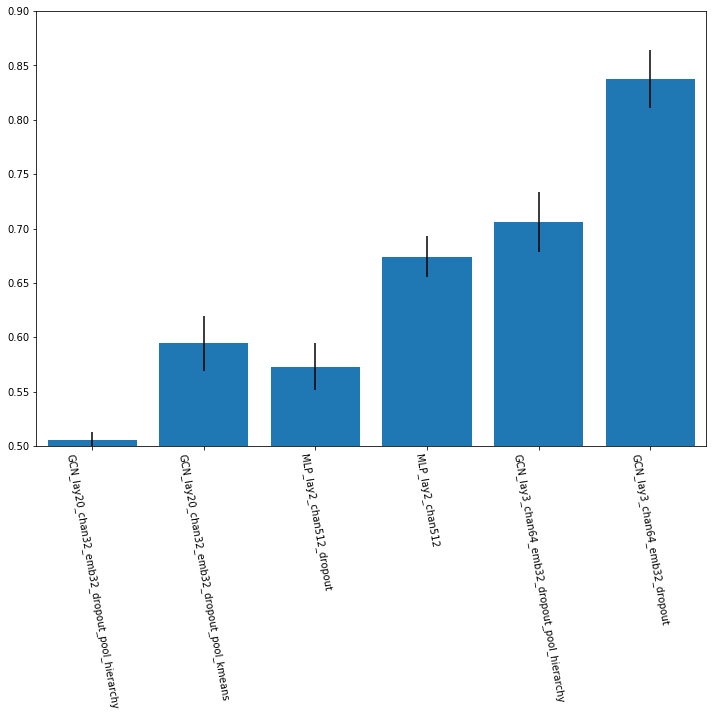

In [36]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.5, 3.6)
plot_train_size = 50

subset = results

q = subset.groupby(['model'])['auc']

stderr = []
mean = []
labels = []
for model in set(subset.model):
    labels.append(model)
    mean.append(q.mean()[model])
    stderr.append(q.std()[model]/np.sqrt(q.count()[model]))

freq_series = pd.Series.from_array(mean)

plt.figure(figsize=(12, 8))
fig = freq_series.plot(kind='bar')

plt.bar(x=range(len(set(subset.model))), height=mean, yerr=stderr)
fig.set_xticklabels(labels)
plt.xticks(rotation=-80)

fig.set_ylim((0.5, 0.9))